# Model - SentenceTransformers

### Imports

In [1]:
import os
import pandas as pd
from iqual import iqualnlp, evaluation, crossval

### Load `annotated (human-coded)` and `unannotated` datasets

In [2]:
data_dir         = "../../data"
human_coded_df   = pd.read_csv(os.path.join(data_dir,"annotated.csv"))
uncoded_df       = pd.read_csv(os.path.join(data_dir,"unannotated.csv"))

### Split the data into training and test sets

In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(human_coded_df,test_size=0.25)
print(f"Train Size: {len(train_df)}\nTest Size: {len(test_df)}")

Train Size: 7470
Test Size: 2490


### Configure training data

In [4]:
### Select Question and Answer Columns
question_col = 'Q_en'
answer_col   = 'A_en'

### Select a code
code_variable = 'marriage'

### Create X and y
X = train_df[[question_col,answer_col]]
y = train_df[code_variable]

### Initiate model

In [5]:
import torch

In [12]:
# Initiate the model class
iqual_model = iqualnlp.Model()

#  Add layers to the model
#  Add text columns, and choose a feature extraction model (Available options: scikit-learn, spacy, sentence-transformers, precomputed (picklized dictionary))
iqual_model.add_text_features(question_col,answer_col,
                              model='all-MiniLM-L6-v2',
                              env='sentence-transformers',
                              device='cuda'
                             )

# Add a classifier layer
# Choose a primary classifier model  (Available options: any scikit-learn classifier)
iqual_model.add_classifier(name="LogisticRegression")

# Add a threshold layer. This is optional, but recommended for binary classification
iqual_model.add_threshold(scoring_metric='f1')

# Compile the model
iqual_model.compile()

Pipeline(steps=[('Input',
                 FeatureUnion(transformer_list=[('question',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function column_selector at 0x00000254018E8820>,
                                                                                      kw_args={'column_name': 'Q_en'})),
                                                                 ('vectorizer',
                                                                  Vectorizer(env='sentence-transformers',
                                                                             model='all-MiniLM-L6-v2'))])),
                                                ('answer',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<fun...
                                                                  Vectorizer(env='sentence-transformers',
                                                                             model='all-MiniLM-L6-v2'))]))])),
                ('Classifier',
                 Classifier(C=1.0, class_weight=None, dual=False,
                            fit_intercept=True, intercept_scaling=1,
                            l1_ratio=None, max_iter=100,
                            model='LogisticRegression', multi_class='auto',
                            n_jobs=None, penalty='l2', random_state=None,
                            solver='lbfgs', tol=0.0001, verbose=0,
                            warm_start=False)),
                ('Threshold', BinaryThresholder())])

### Configure a Hyperparameter Grid for cross-validation + fitting

In [13]:
search_param_config = {
    "Input":{
        "question":{
            "vectorizer":{
                        "model":["all-MiniLM-L6-v2"],
                         "env":["sentence-transformers"],
                         "device":['cuda'] 
                         },
        },
        "answer":{
            "vectorizer":{
                        "model":["all-MiniLM-L6-v2"],
                         "env":["sentence-transformers"],
                         "device":['cuda'] # If `cuda` is available
                         },                        
        },
    },
        "Classifier":{
            "model":["LogisticRegression"],
            "C":[0.001, 0.01, 0.1],
        },
}

CV_SEARCH_PARAMS = crossval.convert_nested_params(search_param_config)

print(CV_SEARCH_PARAMS)

{'Input__question__vectorizer__model': ['all-MiniLM-L6-v2'], 'Input__question__vectorizer__env': ['sentence-transformers'], 'Input__question__vectorizer__device': ['cuda'], 'Input__answer__vectorizer__model': ['all-MiniLM-L6-v2'], 'Input__answer__vectorizer__env': ['sentence-transformers'], 'Input__answer__vectorizer__device': ['cuda'], 'Classifier__model': ['LogisticRegression'], 'Classifier__C': [0.001, 0.01, 0.1]}


### Model training:
Cross-validate over hyperparameters and select the best model

In [14]:
# Scoring Dict for evaluation
scoring_dict = {'f1':evaluation.get_scorer('f1')}

cv_dict = iqual_model.cross_validate_fit(
    X,y,                                # X: Pandas DataFrame of features, y: Pandas Series of labels
    search_parameters=CV_SEARCH_PARAMS, # search_parameters: Dictionary of parameters to use for cross-validation
    cv_method='GridSearchCV',           # cv_method: Cross-validation method to use, options: GridSearchCV, RandomizedSearchCV
    scoring=scoring_dict,               # scoring: Scoring metric to use for cross-validation
    refit='f1',                         # refit: Metric to use for refitting the model
    n_jobs=-1,                           # n_jobs: Number of parallel threads to use  
    cv_splits=3,                        # cv_splits: Number of cross-validation splits
)
print()
print("Average F1 score: {:.3f}".format(cv_dict['avg_test_score']))

.......3 hyperparameters configurations possible.....
Average F1 score: 0.791


### Evaluate model using out sample data (Held out human-coded data)

In [9]:
test_X = test_df[['Q_en','A_en']]
test_y = test_df[code_variable]

f1_score  = iqual_model.score(test_X,test_y,
                              scoring_function=evaluation.get_metric('f1_score'))
print(f"Out-sample F1-score: {f1_score:.3f}")

accuracy  = iqual_model.score(test_X,test_y,
                              scoring_function=evaluation.get_metric('accuracy_score'))
print(f"Out-sample accuracy-score: {accuracy:.3f}")

Out-sample F1-score: 0.825
Out-sample accuracy-score: 0.981


### Predict labels for unannotated data

<AxesSubplot:>

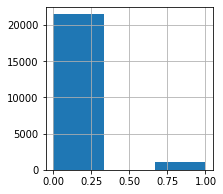

In [10]:
uncoded_df[code_variable+'_pred'] = iqual_model.predict(uncoded_df[['Q_en','A_en']])

uncoded_df[code_variable+"_pred"].hist(figsize=(3,3),bins=3)

### Examples for positive predictions

In [11]:
for idx, row in uncoded_df.loc[(uncoded_df[code_variable+"_pred"]==1),['Q_en','A_en']].sample(3).iterrows():
    print("Q: ",row['Q_en'],"\n","A: ", row['A_en'],sep='')
    print()

Q: If you want to get married?
A: Yes, I want to get married. But the proposal actually says that people have to pay 1 lakh rupees. I don't mean without money.

Q: What other dreams about him?
A: My dream is to study while I'm alive and get married soon.

Q: How do you plan to achieve these?
A: I have saved some money for them. I will borrow some money from people and marry the girls.

